In [1]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

In [2]:
train_set = CIFAR10('~/datasets/cifar10', train=True, download=True)
test_set = CIFAR10('~/datasets/cifar10', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_set.data.shape, train_set.data.dtype

((50000, 32, 32, 3), dtype('uint8'))

Label: 7, class: horse


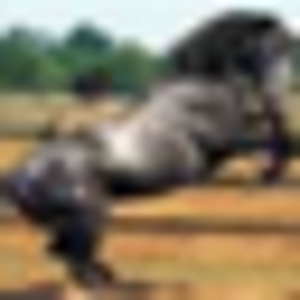

In [5]:
image, label = train_set[113]
print(f'Label: {label}, class: {train_set.classes[label]}')
image.resize((300, 300))

In [6]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_set = CIFAR10('~/datasets/cifar10', train=True, transform=T.ToTensor())
test_set = CIFAR10('~/datasets/cifar10', train=False, transform=T.ToTensor())

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [21]:
def train(num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # images: batch_size x num_channels x height x width
            logits = model(images)
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(images)
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [16]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(  # (3, 32, 32)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # (16, 32, 32)
            nn.MaxPool2d(2),  # (16, 16, 16)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # (32, 16, 16)
            nn.MaxPool2d(2),  # (32, 8, 8)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (64, 8, 8)
            nn.MaxPool2d(2),  # (64, 4, 4)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (128, 4, 4)
            nn.ReLU()
        )

        self.classifier = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # (B, 3, 32, 32)
        feature_map = self.net(x)  # (B, 128, 4, 4)
        feature_vector = feature_map.mean(dim=(2, 3))  # (B, 128)
        logits = self.classifier(feature_vector)  # (B, 10)
        return logits

In [17]:
x = torch.randn(16, 3, 32, 32)
y = torch.randint(low=0, high=10, size=(16, ))
model = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [18]:
model(x).shape

torch.Size([16, 10])

In [19]:
model

ConvNet(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
model.train()
for i in range(1, 1001):
    optimizer.zero_grad()
    logits = model(x)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(loss.item())

2.0858352184295654
2.0415799617767334
1.834212064743042
1.773667573928833
0.987644612789154
0.017222154885530472
0.004574209451675415
0.002720053307712078
0.0019015955040231347
0.0014434433542191982
0.0011533456854522228
0.0009545134380459785
0.0008104299195110798
0.0007016451563686132
0.0006168173858895898
0.0005490512703545392
0.0004937377525493503
0.0004478583869058639
0.00040924909990280867
0.0003763702407013625


In [25]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = None

In [26]:
sum(param.numel() for param in model.parameters())

98730

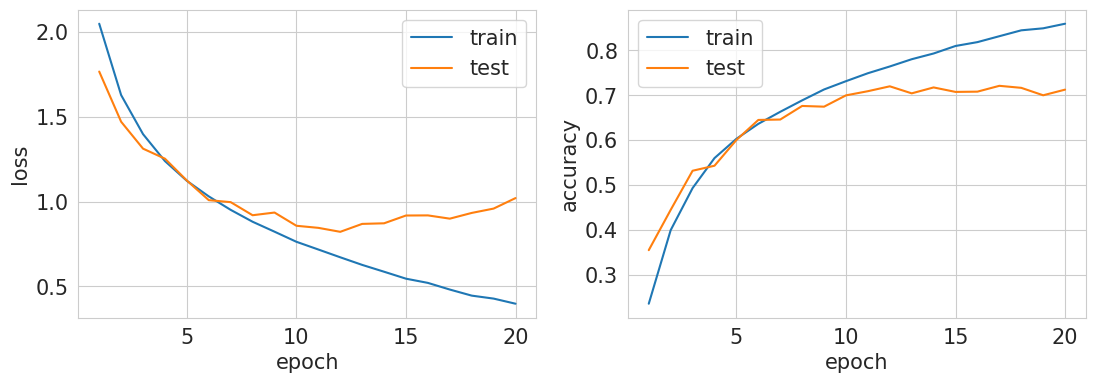

In [27]:
train(num_epochs=20)

In [28]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

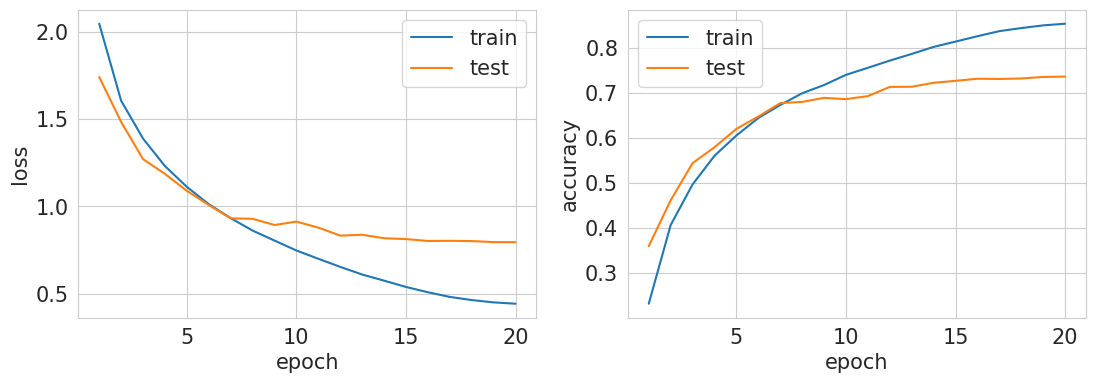

In [29]:
train(num_epochs=20)

In [30]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
train_set = CIFAR10('~/datasets/cifar10', train=True, transform=train_transform)
test_set = CIFAR10('~/datasets/cifar10', train=False, transform=test_transform)

In [32]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

In [33]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

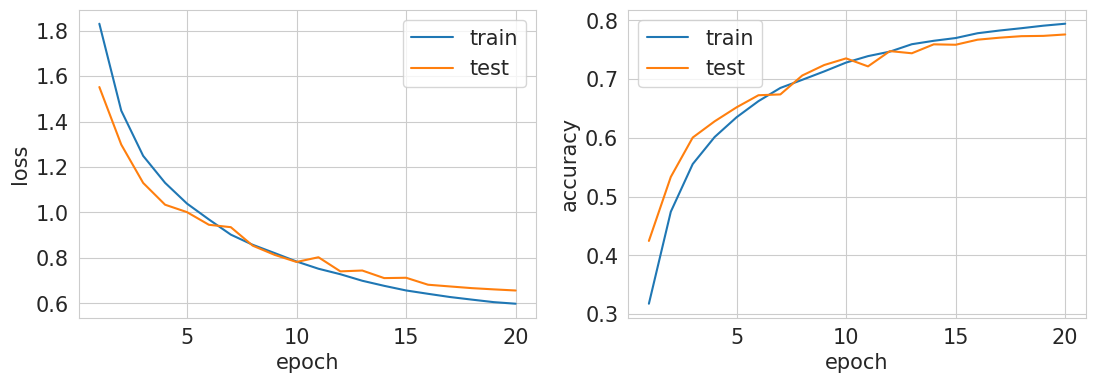

In [34]:
train(num_epochs=20)

In [35]:
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict()
}, 'cifar-model.pt')

In [36]:
!du -sh cifar-model.pt

780K	cifar-model.pt


In [37]:
model = ConvNet()
ckpt = torch.load('cifar-model.pt')
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [54]:
from torch import nn

class StridedConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(  # (3, 32, 32)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # (16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),  # (32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),  # (64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),  # (128, 4, 4)
            nn.ReLU(),
        )

        self.classifier = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # (B, 3, 32, 32)
        feature_map = self.net(x)  # (B, 128, 4, 4)
        feature_vector = feature_map.mean(dim=(2, 3))  # (B, 128)
        logits = self.classifier(feature_vector)  # (B, 10)
        return logits

In [55]:
model = StridedConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [56]:
sum(param.numel() for param in model.parameters())

98730

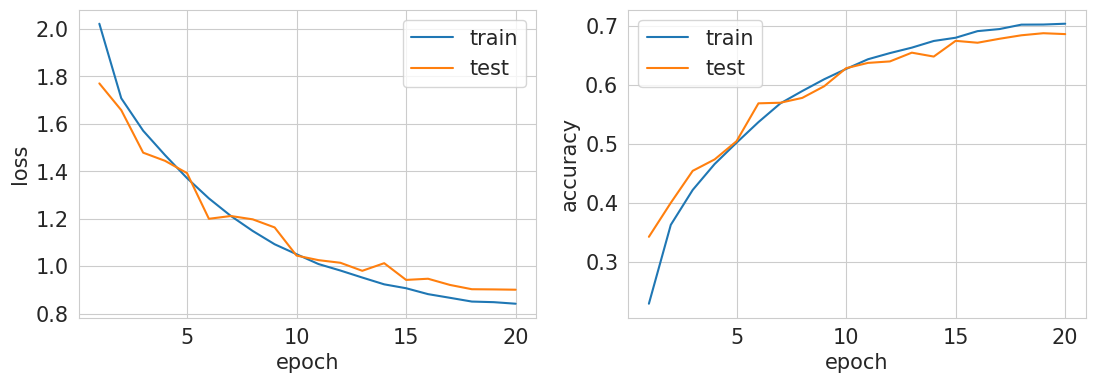

In [57]:
train(num_epochs=20)

In [69]:
def evaluate(num_tta=1):
    model.eval()
    all_probs = []

    for _ in tqdm(range(num_tta), desc='Validating'):
        probs = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(images)
            
            probs.append(logits.softmax(dim=-1))
        
        probs = torch.cat(probs, dim=0)
        all_probs.append(probs)

    probs = torch.stack(all_probs, dim=0).mean(dim=0)
    preds = probs.argmax(dim=-1)
    test_accuracy = (preds.cpu() == torch.tensor(test_loader.dataset.targets)).to(torch.float).mean().item()
    print(f'test accuracy: {100 * test_accuracy:.2f}%')

In [70]:
test_set.transform = test_transform
print('No TTA')
evaluate()

No TTA


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

test accuracy: 68.55%


In [71]:
test_set.transform = train_transform
print('TTA=5')
evaluate(num_tta=5)

TTA=5


Validating:   0%|          | 0/5 [00:00<?, ?it/s]

test accuracy: 71.05%


In [73]:
test_set.transform = train_transform
print('TTA=20')
evaluate(num_tta=20)

TTA=20


Validating:   0%|          | 0/20 [00:00<?, ?it/s]

test accuracy: 71.83%
